<a href="https://colab.research.google.com/github/jollygoodjacob/STF/blob/main/STF_starfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STARFM for Spatiotemporal Fusion

This Google Colab script is an implementation of the STARFM (Spatial and Temporal Adaptive Reflectance Fusion Model) algorithm, modified for use with UAV and Planet data. It combines high-resolution UAV imagery and low-resolution Planet satellite imagery from two time points to predict a high-resolution synthetic image at a future time.

## Install required packages

First, we need to install rasterio using pip, as Google Colab does not come preinstalled with this package.

In [1]:
!pip install rasterio
!pip install zarr
!pip install dask.array

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement dask.array (from versions: none)
ERROR: No matching distribution found for dask.array


## Mount Google Drive and Load Functions for STARFM

Next, we want to mount our Google Drive so that we can share data with our Google Colab script. We need both the starfm4py.py and parameters.py functions that are required to run the script, as well as our UAV and Planet data.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Add your module directory to the Python path
import sys
sys.path.append('/content/drive/MyDrive/STF/STARFM')

# (Optional) Set working directory for reading TIFFs or output
import os
os.chdir('/content/drive/MyDrive/STF/STARFM')

# Enable auto-reload of modules
%load_ext autoreload
%autoreload 2

# Try importing your values
from parameters import path, sizeSlices
print("Imported values:", path, sizeSlices)

# Try importing the STARFM module
import starfm4py as stp
print("Successfully imported starfm4py")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imported values: STARFM_demo/ 150
Successfully imported starfm4py


## Apply STARFM to our data

This script performs spatiotemporal image fusion using the STARFM (Spatial and Temporal Adaptive Reflectance Fusion Model) algorithm. It combines high-resolution UAV imagery and low-resolution Planet satellite imagery from two time points to predict a high-resolution image at a future time. The workflow includes:

- Loading UAV from one time step (t₀) and Planet images from two time steps (t₀ and t₁)

- Partitioning the images into manageable tiles,

- Stacking them into memory-efficient arrays using Dask,

- Applying the STARFM model chunk by chunk,

- Merging and writing the fused output (synthetic UAV t₁) to a GeoTIFF file,

- Displaying the input and predicted images for comparison.



Done partitioning!
Done stacking!
Processing...
Done spectral distance! dask.array<truediv, shape=(78150, 961), dtype=float32, chunksize=(521, 961), chunktype=numpy.ndarray>
Done temporal distance! dask.array<truediv, shape=(78150, 961), dtype=float32, chunksize=(521, 961), chunktype=numpy.ndarray>
Done spatial distance! dask.array<array, shape=(961,), dtype=float64, chunksize=(961,), chunktype=numpy.ndarray>
Done comb distance! dask.array<mul, shape=(78150, 961), dtype=float64, chunksize=(521, 961), chunktype=numpy.ndarray>
Done similarity threshold! dask.array<truediv, shape=(78150,), dtype=float32, chunksize=(521,), chunktype=numpy.ndarray>
Done similarity pixels! dask.array<where, shape=(78150, 961), dtype=int64, chunksize=(521, 961), chunktype=numpy.ndarray>
Done filtering! dask.array<mul, shape=(78150, 961), dtype=int64, chunksize=(521, 961), chunktype=numpy.ndarray>
Done weighting! dask.array<rechunk-merge, shape=(78150, 961), dtype=float64, chunksize=(521, 961), chunktype=numpy

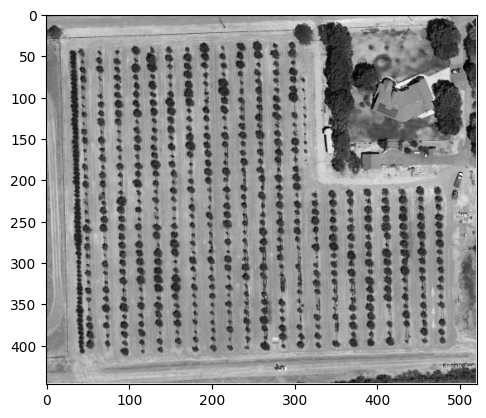

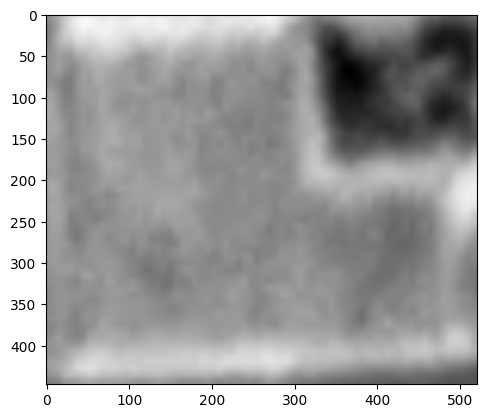

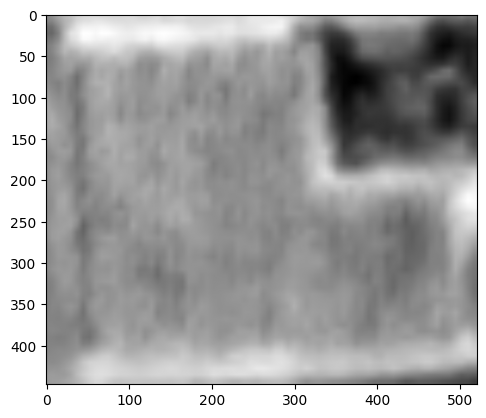

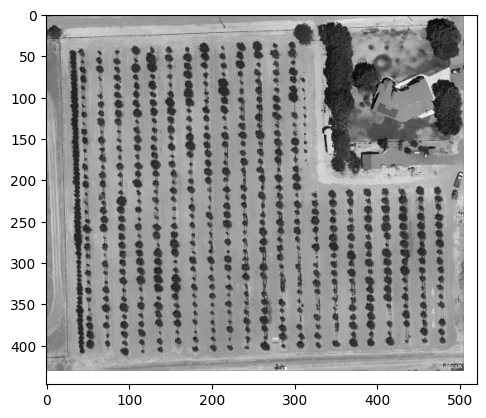

In [4]:
# === Import Required Libraries ===

import time  # For measuring execution time
import rasterio  # For reading and writing raster (image) files, especially geospatial data like GeoTIFFs
import numpy as np  # For numerical operations and array manipulation
#import starfm4py as stp  # STARFM fusion module (commented out, assuming user would uncomment when used)
import matplotlib.pyplot as plt  # For plotting images using matplotlib
#from parameters import (path, sizeSlices)  # Optional: External parameters for reusability (commented out)


start = time.time()  # Start a timer to measure how long the whole script takes

# === Load Raster Data ===

# Load the high-resolution UAV image at time t0
product = rasterio.open('/content/drive/MyDrive/STF/STARFM/20220802_RGB_UAV.tif')
profile = product.profile  # Get metadata (e.g., dimensions, datatype, CRS, etc.)

# Read the first band (assumes grayscale or single-band processing for simplicity)
UAVt0 = rasterio.open('/content/drive/MyDrive/STF/STARFM/20220802_RGB_UAV.tif').read(1)

# Load the Planet satellite images at time t0 and t1
Planett0 = rasterio.open('/content/drive/MyDrive/STF/STARFM/20220802_RGB_Planet.tif').read(1)
Planett1 = rasterio.open('/content/drive/MyDrive/STF/STARFM/20220812_RGB_Planet.tif').read(1)

# === Define Temporary Paths for Partitioned Tiles ===

# These folders will store tiles (image patches) generated during partitioning
path_fineRes_t0 = 'Temporary/Tiles_fineRes_t0/'
path_coarseRes_t0 = 'Temporary/Tiles_coarseRes_t0/'
path_coarseRes_t1 = 'Temporary/Tiles_fcoarseRes_t1/'

# === Partition the Images ===
# This step breaks the images into smaller tiles to be processed efficiently

fine_image_t0_par = stp.partition(UAVt0, path_fineRes_t0)  # High-res UAV image
coarse_image_t0_par = stp.partition(Planett0, path_coarseRes_t0)  # Coarse Planet image at t0
coarse_image_t1_par = stp.partition(Planett1, path_coarseRes_t1)  # Coarse Planet image at t1

print("Done partitioning!")

# === Stack the Partitioned Tiles into Dask Arrays ===
# Dask arrays allow chunked and parallel computation for large data

S2_t0 = stp.da_stack(path_fineRes_t0, UAVt0.shape)      # Stack of fine resolution UAV tiles
S3_t0 = stp.da_stack(path_coarseRes_t0, Planett0.shape)  # Stack of Planet t0 tiles
S3_t1 = stp.da_stack(path_coarseRes_t1, Planett1.shape)  # Stack of Planet t1 tiles

# Define the shape of each processing block: (number of rows per slice, total number of columns)
shape = (sizeSlices, UAVt0.shape[1])

print("Done stacking!")

# === STARFM Fusion Prediction ===
# This section applies the STARFM algorithm to sequential chunks of the input image stacks.
# Because the entire image may be too large to process in memory, we divide it into chunks (tiles)
# and process each one individually. The outputs are concatenated to form the full fused image.

# Calculate the number of pixels in each chunk:
# Each chunk has 'sizeSlices' number of rows and the full number of columns (shape[1])
# So the number of pixels per chunk is sizeSlices * number of columns
step = sizeSlices * shape[1]

# The total number of pixels in the image (flattened)
end_index = UAVt0.size

# Main loop: iterate over the image in pixel chunks of size 'step'
for i in range(0, end_index, step):

    # Calculate the end of the current chunk, ensuring we don’t exceed the image bounds
    # If the last chunk is smaller than the step, this safely captures the remaining pixels
    end_i = min(i + step, end_index)

    # Extract the corresponding chunk from each of the three stacked images (flattened Dask arrays)
    # The slices are 1D (rows in flattened image), but the data itself represents 2D image patches
    fine_image_t0 = S2_t0[i:end_i, :]      # High-res image at t0
    coarse_image_t0 = S3_t0[i:end_i, :]    # Low-res image at t0
    coarse_image_t1 = S3_t1[i:end_i, :]    # Low-res image at t1

    # Compute the actual number of rows in this chunk
    # This is done by dividing the number of pixels in the chunk by the number of columns
    rows = end_i - i
    current_shape = (rows // UAVt0.shape[1], UAVt0.shape[1])  # (rows, cols)

    # Apply the STARFM fusion model to predict high-res reflectance at time t1
    # Inputs: fine image at t0, coarse image at t0, coarse image at t1,
    # metadata (profile), and the shape of the current chunk
    prediction = stp.starfm(fine_image_t0, coarse_image_t0, coarse_image_t1, profile, current_shape)

    # Append the predicted chunk to the growing prediction array
    if i == 0:
        predictions = prediction  # Initialize on first iteration
    else:
        # Concatenate subsequent chunks vertically (row-wise)
        predictions = np.append(predictions, prediction, axis=0)



# === Write Prediction to GeoTIFF File ===

print('Writing product...')

# Update metadata for output (set datatype and number of bands)
profile = product.profile
profile.update(dtype='float64', count=1)

file_name = path + 'prediction.tif'  # Output file path

# Write the final fused prediction image to disk
result = rasterio.open(file_name, 'w', **profile)
result.write(predictions, 1)  # Write to the first band
result.close()


# === Report Total Runtime ===

end = time.time()
print("Done in", (end - start)/60.0, "minutes!")


# === Visualize the Inputs and Output ===

# UAV image (high-resolution, time t0)
plt.imshow(UAVt0)
plt.gray()
plt.show()

# Planet image (coarse-resolution, time t0)
plt.imshow(Planett0)
plt.gray()
plt.show()

# Planet image (coarse-resolution, time t1)
plt.imshow(Planett1)
plt.gray()
plt.show()

# Predicted high-resolution image for time t1 (fused)
plt.imshow(predictions)
plt.gray()
plt.show()